## House Price Prediction 2

In this second part of the project I will use the processed datasets to build a simple model. The goal here is to show that even with no complex feature engineering we can build a model that with a good generalization ability; that is, it makes good predictions. Since this project is based on the Kaggle competition: . We can submit the final solition and get the final score of the model on previously unseen data. The solution presented in this notebook scores to the position 479 in the ranking   

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
# Load datasets
df_train = pd.read_csv('train_end.csv')
df_val = pd.read_csv('val_end.csv')
df_test = pd.read_csv('test_end.csv')

In [153]:
# Let's work with numerical columns only
df_train_num = df_train.select_dtypes(exclude='object')
df_val_num = df_val.select_dtypes(exclude='object')

In [4]:
correlations = df_train_num.corr()

<AxesSubplot:>

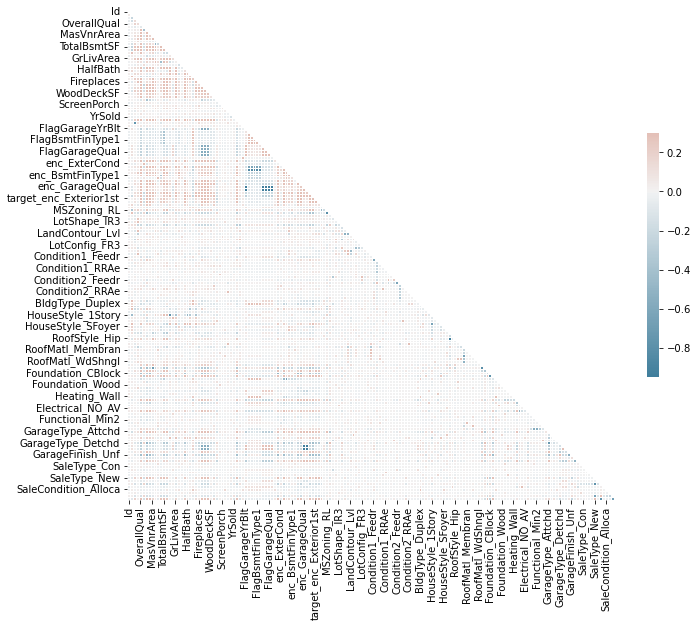

In [5]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlations, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Since all features are numeric we can compute statistical correlations between all pairs of variables. This can give us an idea about the most important features in terms of their relationship with the SalePrice target. 

In [6]:
# Top 20 features that show a high correlation with SalePrice
correlations['SalePrice'].sort_values()[-20:]

Fireplaces                 0.469078
MasVnrArea                 0.486244
Foundation_PConc           0.495016
target_enc_MSSubClass      0.495070
YearRemodAdd               0.504283
YearBuilt                  0.516639
GarageYrBlt                0.519248
TotRmsAbvGrd               0.534728
FullBath                   0.552260
enc_BsmtQual               0.591794
TotalBsmtSF                0.605076
1stFlrSF                   0.605155
GarageArea                 0.607390
GarageCars                 0.631059
enc_KitchenQual            0.661119
enc_ExterQual              0.683481
GrLivArea                  0.705046
target_enc_neighborhood    0.731783
OverallQual                0.789269
SalePrice                  1.000000
Name: SalePrice, dtype: float64

A good option fo build a first model is a random forest regressor since they are flexible enough to capture important relationships between features and allow for a simple interpretation of the results. Furthermore, this type of models do not require scaling features.

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

In [8]:
# Prepare data for model

X_train = df_train_num.drop('SalePrice', axis=1)
y_train = df_train_num['SalePrice']

X_test = df_val_num.drop('SalePrice', axis=1)
y_test = df_val_num['SalePrice']

y_train_log = np.log(y_train.values)
y_test_log = np.log(y_test.values)

In [73]:
# Create a list of hyperparamaters and use cross-validation to select to best model.
n_estimators = [20, 50, 75, 100, 125, 150]
scores = []
for n_est in n_estimators:
    regr = RandomForestRegressor(n_estimators=n_est)
    #regr.fit(X_train, y_train)
    score = cross_val_score(regr, X_train, y_train_log, cv=10, scoring='neg_mean_absolute_error')
    #preds = regr.predict(X_test)
    #score = mean_absolute_error(y_test, preds)
    scores.append(score)

In [74]:
mean_scores =np.array([np.mean(abs(score)) for score in scores])
std_scores =np.array([np.std(abs(score)) for score in scores])

In [75]:
mean_scores

array([0.10288624, 0.1013321 , 0.09968686, 0.1000192 , 0.09899629,
       0.0992274 ])

In [76]:
# Train useing best parameter
regr = RandomForestRegressor(n_estimators=125)
regr.fit(X_train_scaled, y_train_log)
y_pred = np.exp(regr.predict(X_test_scaled))
    
print(mean_absolute_error(y_test, y_pred))

15742.306050367164


In [41]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [49]:
alphas = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
scores = []
for alpha in alphas:
    regr = Lasso(alpha=alpha, max_iter=2000)
    #regr.fit(X_train, y_train)
    score = cross_val_score(regr, X_train, y_train_log, cv=10, scoring='neg_mean_absolute_error')
    #preds = regr.predict(X_test)
    #score = mean_absolute_error(y_test, preds)
    scores.append(score)

In [50]:
mean_scores =np.array([np.mean(abs(score)) for score in scores])
std_scores =np.array([np.std(abs(score)) for score in scores])

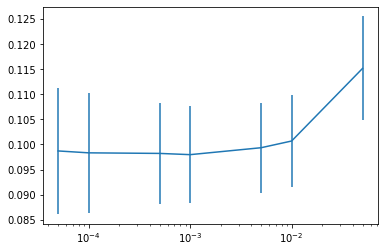

In [54]:
plt.errorbar(alphas, y=mean_scores, yerr=std_scores)
plt.xscale('log')

In [11]:
# We can also try lasso regression
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train_log)
y_preds = np.exp(lasso_model.predict(X_test))

print(mean_absolute_error(y_test, y_preds))

15119.999906660621


Note a small improvement when using Lasso regression . Now we can apply a simple feature engineering to improve the performance of the model.

In [58]:
# Let's start by looking to most correlated features
correlations['SalePrice'].sort_values()[-20:]

Fireplaces                 0.469115
MasVnrArea                 0.486227
target_enc_MSSubClass      0.494999
Foundation_PConc           0.495506
YearRemodAdd               0.504735
YearBuilt                  0.517148
GarageYrBlt                0.519740
TotRmsAbvGrd               0.534800
FullBath                   0.552554
enc_BsmtQual               0.591990
1stFlrSF                   0.605286
TotalBsmtSF                0.605447
GarageArea                 0.607373
GarageCars                 0.631141
enc_KitchenQual            0.661411
enc_ExterQual              0.683522
GrLivArea                  0.705035
target_enc_neighborhood    0.732465
OverallQual                0.789379
SalePrice                  1.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

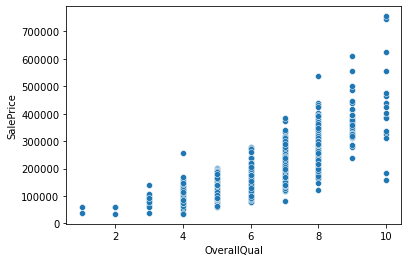

In [64]:
sns.scatterplot(x='OverallQual', y='SalePrice', data=df_train_num)

<AxesSubplot:xlabel='target_enc_neighborhood', ylabel='SalePrice'>

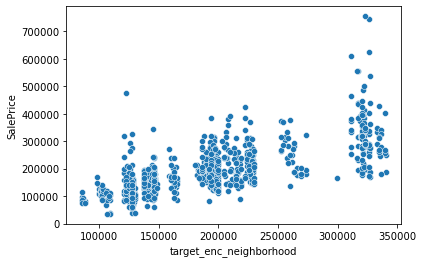

In [65]:
sns.scatterplot(x='target_enc_neighborhood', y='SalePrice', data=df_train_num)

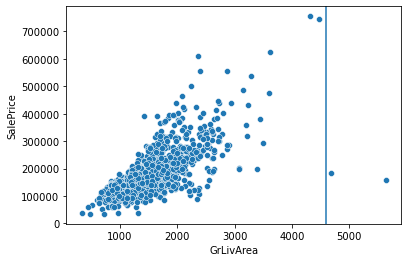

In [67]:
# We can observe two apparent outliers
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_train_num)
plt.axvline(4600)

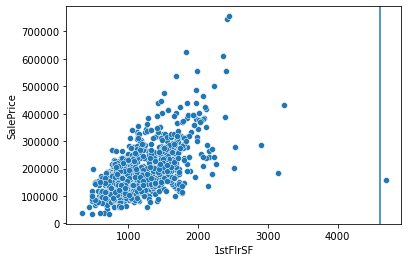

In [69]:
# We can observe two apparent outliers
sns.scatterplot(x='1stFlrSF', y='SalePrice', data=df_train_num)
plt.axvline(4600)

In [100]:
# For the moment let's keep these points and only scale features:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
alphas = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
scores = []
for alpha in alphas:
    regr = Lasso(alpha=alpha, max_iter=2000)
    #regr.fit(X_train, y_train)
    score = cross_val_score(regr, X_train_scaled, y_train_log, cv=10, scoring='neg_mean_absolute_error')
    #preds = regr.predict(X_test)
    #score = mean_absolute_error(y_test, preds)
    scores.append(score)

/home/betor94/anaconda3/envs/DS/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.039e-02, tolerance: 1.608e-02
  model = cd_fast.enet_coordinate_descent(


In [16]:
mean_scores =np.array([np.mean(abs(score)) for score in scores])
std_scores =np.array([np.std(abs(score)) for score in scores])

In [31]:
mean_scores, std_scores

(array([0.12432207, 0.0989102 , 0.09684578, 0.0960314 , 0.09731441,
        0.09944978, 0.0998047 ]),
 array([0.01366252, 0.01057006, 0.01002566, 0.01175867, 0.01285499,
        0.0138403 , 0.0139647 ]))

In [37]:
# We can also try lasso regression
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_scaled, y_train_log)
y_preds = np.exp(lasso_model.predict(X_test_scaled))

print(mean_absolute_error(y_test, y_preds))

13713.27602699672


In [18]:
# First test 
X_test_test = df_test.select_dtypes(exclude='object') 
X_test_test_scaled= scaler.transform(X_test_test)

In [19]:
y_preds = np.exp(lasso_model.predict(X_test_test_scaled))

In [30]:
ids = df_test['Id']

In [27]:
# Load data into dataframe to submit solution
ids = df_test['Id']
submissions = pd.DataFrame({'Id':ids, 'SalePrice':y_preds})
submissions

,Id,SalePrice
0,1461,130493.458035
1,1462,154339.232624
2,1463,175459.126936
3,1464,192436.787890
4,1465,203311.111970
...,...,...
1454,2915,85846.338623
1455,2916,82053.400349
1456,2917,157831.245705
1457,2918,118163.699878


In [29]:
submissions.to_csv('submission1.csv', index=False)

In [67]:
alphas=np.logspace(-5, 5, 11)
scores = []
for alpha in alphas:
    regr = Ridge(alpha=alpha, max_iter=2000)
    #regr.fit(X_train, y_train)
    score = cross_val_score(regr, X_train_scaled, y_train_log, cv=10, scoring='neg_mean_absolute_error')
    #preds = regr.predict(X_test)
    #score = mean_absolute_error(y_test, preds)
    scores.append(score)

In [68]:
mean_scores =np.array([np.mean(abs(score)) for score in scores])
std_scores =np.array([np.std(abs(score)) for score in scores])

In [69]:
mean_scores, std_scores

(array([0.10051732, 0.10051724, 0.10051653, 0.10050942, 0.10044274,
        0.09995033, 0.09903712, 0.0983592 , 0.10201452, 0.16412035,
        0.27919194]),
 array([0.0141311 , 0.01413106, 0.01413068, 0.01412686, 0.01408674,
        0.01367479, 0.0117048 , 0.01078531, 0.01257265, 0.02106899,
        0.02625916]))

In [72]:
# We can also try lasso regression
ridge_model = Ridge(alpha=10.)
ridge_model.fit(X_train_scaled, y_train_log)
y_preds = np.exp(ridge_model.predict(X_test_scaled))

print(mean_absolute_error(y_test, y_preds))

13986.124273346264


In [38]:
reg = LinearRegression()
reg_scores = cross_val_score(regr, X_train_scaled, y_train_log, cv=10, scoring='neg_mean_squared_error')

In [77]:
np.abs(reg_scores).mean()

0.04319594183211445

In [79]:
linreg_model = LinearRegression()
linreg_model.fit(X_train_scaled, y_train_log)
y_preds = np.exp(linreg_model.predict(X_test_scaled))

print(mean_absolute_error(y_test, y_preds))

13683.65438800549


We can try to improve our model by removing the outliers previously detected. This measure can increase the correlation with SalePrice.

In [296]:
df_train_num = df_train.select_dtypes(exclude='object')
df_val_num = df_val.select_dtypes(exclude='object')

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

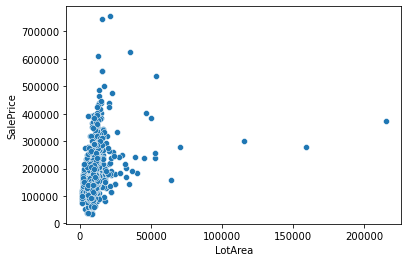

In [276]:
sns.scatterplot(x='LotArea', y='SalePrice', data=df_train_num)

In [141]:
df_train_num[df_train_num['LotArea']>100000]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
359,250,50,0.0,159000,6,7,1958,2006,472.0,697,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
875,314,20,150.0,215245,7,5,1965,1965,0.0,1236,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1023,707,20,0.0,115149,7,5,1971,2002,351.0,1219,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [297]:
df_train_num[df_train_num['LotFrontage']>200]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
259,1299,60,313.0,63887,10,5,2008,2008,796.0,5644,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
504,935,20,313.0,27650,7,7,1960,2007,0.0,425,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [277]:
# Let's remove outliers
cond1 = df_train_num['GrLivArea']<4600
cond2 = df_train_num['BsmtFinSF1']<4000
cond3 = df_train_num['LotArea']<100000
df_train_num = df_train_num[(cond1) & (cond2) & (cond3)]

X_train = df_train_num.drop('SalePrice', axis=1)
y_train = df_train_num['SalePrice']

X_test = df_val_num.drop('SalePrice', axis=1)
y_test = df_val_num['SalePrice']

y_train_log = np.log(y_train.values)
y_test_log = np.log(y_test.values)

<AxesSubplot:xlabel='target_enc_neighborhood', ylabel='SalePrice'>

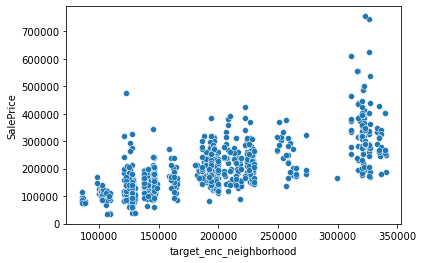

In [278]:
sns.scatterplot(x='target_enc_neighborhood', y='SalePrice', data=df_train_num)
#plt.axvline(4600)

In [279]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_test = df_test.select_dtypes(exclude='object') 
X_test_test_scaled= scaler.transform(X_test_test)

In [281]:
alphas = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
scores = []
for alpha in alphas:
    regr = Lasso(alpha=alpha, max_iter=4000)
    #regr.fit(X_train, y_train)
    score = cross_val_score(regr, X_train_scaled, y_train_log, cv=10, scoring='neg_mean_absolute_error')
    #preds = regr.predict(X_test)
    #score = mean_absolute_error(y_test, preds)
    scores.append(score)

/home/betor94/anaconda3/envs/DS/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e-02, tolerance: 1.575e-02
  model = cd_fast.enet_coordinate_descent(


In [282]:
mean_scores =np.array([np.mean(abs(score)) for score in scores])
std_scores =np.array([np.std(abs(score)) for score in scores])

In [283]:
mean_scores, std_scores

(array([0.11192821, 0.08596062, 0.08391074, 0.08551059, 0.08647177,
        0.08830166, 0.08860209]),
 array([0.0125411 , 0.0098745 , 0.01011561, 0.01022663, 0.00926646,
        0.00834818, 0.00821891]))

In [285]:
# We can also try lasso regression
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_scaled, y_train_log)
y_preds = np.exp(lasso_model.predict(X_test_scaled))

print(mean_absolute_error(y_test, y_preds))

13338.225535546098


In [286]:
y_preds = np.exp(lasso_model.predict(X_test_test_scaled))

In [287]:
ids = df_test['Id']
submissions = pd.DataFrame({'Id':ids, 'SalePrice':y_preds})
submissions

,Id,SalePrice
0,1461,129411.062848
1,1462,158567.086152
2,1463,179165.036852
3,1464,193196.330218
4,1465,199930.055569
...,...,...
1454,2915,87451.638515
1455,2916,82766.420466
1456,2917,163678.425198
1457,2918,117404.497627


In [288]:
submissions.to_csv('submission7.csv', index=False)

In [229]:
from sklearn.inspection import permutation_importance

In [305]:
r = permutation_importance(lasso_model, X_test_scaled, y_test_log,
                           n_repeats=10, scoring='neg_mean_absolute_error',
                           random_state=0)

In [306]:
r.importances_mean.argsort()

array([105, 111, 109, 110,  83, 150, 112,  33,  54,  69, 126,  51,  56,
        89, 152,  18, 108, 161, 166,  72,  85, 144, 106,  49, 138, 135,
       134, 133,  71, 139, 141, 130,  75,  76, 127, 125,  79, 123,   8,
       121,  92,  11, 114, 107, 115, 104, 103, 116, 117, 143,  99,  97,
        96,  95,  94,  93, 119,  91,  98, 120,  64, 113,  60,  39,  35,
        34,  41, 151,  42,  43,  44,  45,  46, 149,  47,  48, 148,  15,
       155,  53, 158,  14,  25, 160, 164,  70,  87,  31,  38,  36, 145,
       147, 163,  55,  40, 154, 153, 146,  80,  86,  90,  82,  23, 157,
        73,  88, 136, 156, 118,  52,   1,   0,  78,  21,  63, 131,  77,
        29,  19,  62, 162,  50, 129, 101,  74,  37,  28, 128, 102,  27,
         2,  81,  13, 122,  17,  30,  59, 100,  10, 140,  58, 142,   7,
       124,  57,  22, 137,  20, 132,  24,  32,  66,  84,  26,   3, 165,
       159,   6,   9,  12,  61,  65,  68,   5,   4,  67,  16])

In [293]:
r.importances_mean[61]

0.009593031683948428